In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [446]:
evds=evdsAPI('dsIC3fiGlu')


In [447]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4617,13-10-2023,27.7576
4618,16-10-2023,27.7939
4619,17-10-2023,27.8865
4620,18-10-2023,27.9221


In [448]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [449]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


In [450]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [451]:


inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


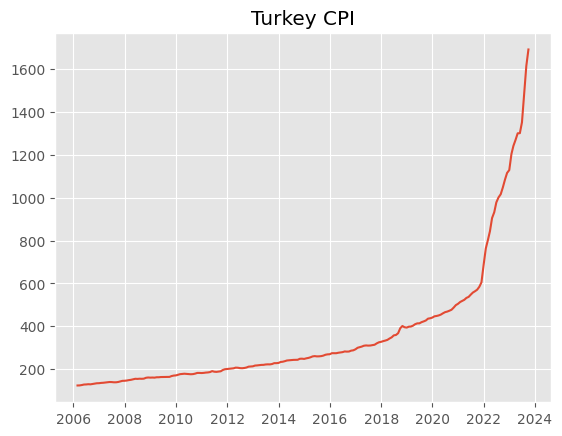

In [452]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure()
plt.title("Turkey CPI")

plt.plot(df)
plt.show()


In [453]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [454]:
dates= pd.date_range('2006-02-01','2023-11-01' , freq='1M')

            
df6=df6.set_index(dates)

df6["Onceki USD/TL"]=df6["USD/TL"].shift(1)
df6.iloc[0,1]=1.32
df6


,USD/TL,Onceki USD/TL
2006-02-28,1.326535,1.320000
2006-03-31,1.335139,1.326535
2006-04-30,1.337345,1.335139
2006-05-31,1.420659,1.337345
2006-06-30,1.600536,1.420659
...,...,...
2023-06-30,23.106042,19.719514
2023-07-31,26.470338,23.106042
2023-08-31,26.999127,26.470338
2023-09-30,26.989448,26.999127


In [455]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del money["Tarih"]
money['Tarih'] = pd.to_datetime(money['YEARWEEK'] + '-1', format='%Y-%W-%w')
money = money.groupby(money['Tarih'].dt.to_period('M'))['TP_PR_ARZ13'].mean()
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(df6.index)
money

,Para Arzi
2006-02-28,2.424295
2006-03-31,2.473023
2006-04-30,2.514337
2006-05-31,2.648480
2006-06-30,2.794302
...,...
2023-06-30,104.034758
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258


In [456]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4610,04-10-2023,89.83
4611,05-10-2023,88.28
4612,06-10-2023,87.86
4613,09-10-2023,91.37


In [457]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [458]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [459]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10


In [460]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870


In [461]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-06-30,95.646045
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870


In [462]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
208,2023-6,12.84
209,2023-7,17.50
210,2023-8,23.50
211,2023-9,31.00


Text(0.5, 1.0, 'TCMB Fonlama Faizi')

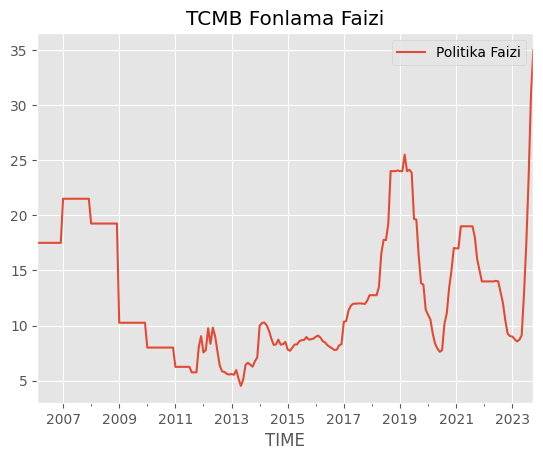

In [463]:
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz.plot(label="TCMB Fonlama Faizi")
plt.title("TCMB Fonlama Faizi")

In [464]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.2980


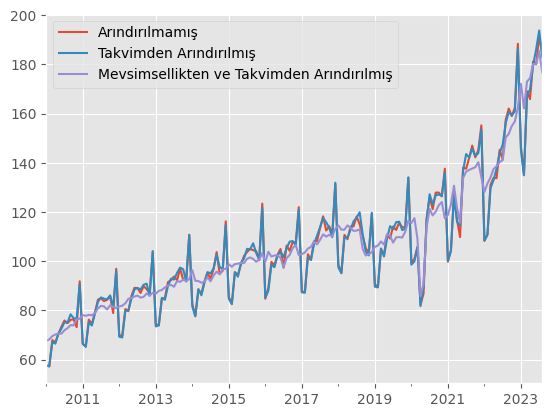

In [465]:
perakende=pd.read_excel("C:/Users/Bora/Downloads/perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:169,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:169,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-09-01",freq="1M"))
perakende1.plot()
plt.legend()






In [466]:
motorin=pd.read_excel("C:/Users/Bora/Downloads/motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-10-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-05-31,18.920000
2023-06-30,22.100000
2023-07-31,29.480000
2023-08-31,37.370000


In [467]:
sanayi=evds.get_data(["TP.SANAYREV4.Y1"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
sanayi=sanayi.set_index(pd.date_range(start="2006-02-01",end="2023-09-01",freq="1M"))
del sanayi["Tarih"]
sanayi.columns=["Sanayi"]
sanayi

,Sanayi
2006-02-28,55.819129
2006-03-31,65.933232
2006-04-30,62.501869
2006-05-31,66.499838
2006-06-30,67.519860
...,...
2023-04-30,129.873251
2023-05-31,149.379361
2023-06-30,137.891848
2023-07-31,145.483816


In [468]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-11-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-06-30,39.5920
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560


In [469]:
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate="30-09-2023",frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-10-30",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-05-31,7.37
2023-06-30,7.55
2023-07-31,7.70
2023-08-31,6.81


In [470]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate="30-10-2023",frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-09-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-04-30,2.292927e+09
2023-05-31,2.348115e+09
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09


In [471]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.head(211)
#data["Shock"]=0
#data.iloc[-1,8]=1.0
#data.iloc[-2,8]=1.0
data=data.dropna(axis=0)
#data["MevduatFaizi"]=mfaiz["Mevduat Faizi"]

data

,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,TÜFE
2010-04-30,0.478728,2.045229,0.713406,0.918462,-2.890475,0.366513,3.033220,0.596780
2010-05-31,0.646630,1.135924,-0.856462,0.610769,4.442741,0.729264,3.592510,-0.358182
2010-06-30,0.922501,0.955408,-0.175370,-0.094972,4.517071,-0.769974,3.358199,-0.561672
2010-07-31,1.054885,2.107244,-1.581105,1.974389,0.720416,0.769773,3.257982,-0.480117
2010-08-31,-0.714734,2.007924,1.520561,1.144214,-3.644655,0.587551,2.661164,0.402974
...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,3.880167,-1.492537,0.772387,-14.132513,10.507274,5.406548,2.385509
2023-05-31,1.507585,4.857908,-7.526882,3.315070,15.019343,2.663712,3.535416,0.043076
2023-06-30,7.066073,0.788974,16.807611,-0.030212,-7.690161,2.406884,5.711697,3.920498
2023-07-31,11.475241,9.567224,33.393665,2.970482,5.505741,9.689321,5.675617,9.488824


In [472]:
['Motorin', 'Perakende Satış', 'Zam', 'ParaArzi', 'Mevduat Faizi']
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi',"TÜFE"]]
data.iloc[7,4]=11.01
data.iloc[19,4]=12.3
data.iloc[31,4]=29.32
data.iloc[43,4]=7.92
data.iloc[55,4]=14.17
data.iloc[67,4]=25.45
data.iloc[79,4]=15
data.iloc[91,4]=26.56
data.iloc[103,4]=50
data.iloc[109,4]=29.31
data.iloc[115,4]=54.66
data.iloc[121,4]=34
data

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,TÜFE
2013-06-30,1.608806,2.388347,0.317048,9.9950,0.0,-0.719400,0.62,1.640855,0.398263,4.506935,6.8000,0.763393
2013-07-31,2.430904,2.487831,-0.866441,10.9200,0.0,2.713011,0.74,2.646003,0.170717,2.215850,7.7375,0.311161
2013-08-31,2.336032,0.775496,2.611863,11.8260,0.0,-17.189911,0.74,1.746407,1.296896,2.497005,8.3520,-0.103399
2013-09-30,2.122082,3.333106,-0.400995,12.7450,0.0,24.131580,0.77,2.481161,0.853359,3.104101,8.7700,0.765042
2013-10-31,1.013333,-1.751603,1.029442,12.8900,0.0,-8.904150,0.65,2.686764,0.881470,1.070377,8.4750,1.799830
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,-1.492537,0.772387,29.2275,0.0,-14.132513,7.51,3.880167,10.507274,5.406548,28.3425,2.385509
2023-05-31,1.507585,-7.526882,3.315070,32.0225,0.0,15.019343,7.37,4.857908,2.663712,3.535416,31.4625,0.043076
2023-06-30,7.066073,16.807611,-0.030212,38.5600,0.0,-7.690161,7.55,0.788974,2.406884,5.711697,39.5920,3.920498
2023-07-31,11.475241,33.393665,2.970482,45.8250,34.0,5.505741,7.70,9.567224,9.689321,5.675617,33.1250,9.488824


<Axes: >

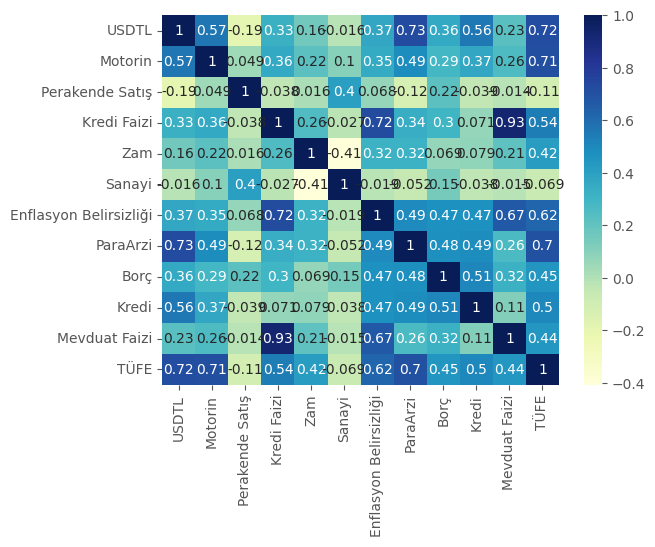

In [473]:
import seaborn as sns
sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)

In [520]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
model=sm.OLS(y_train,X_train).fit()

        

rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [521]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error

features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [476]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 12):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
        reg.fit(X_train_subset, y_train)
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği']
En iyi MSE değeri: 1.0459152183007865


In [522]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [478]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)
tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))


In [479]:
reg = linear_model.ElasticNet(random_state=0)
reg.fit(X_train,y_train)
tahminler["ElasticNet Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["ElasticNet Regression"])))


In [480]:
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)
tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))


In [523]:
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Kredi', 'Mevduat Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
model = MLPRegressor(random_state=1, max_iter=500000)
model.fit(X_train, y_train)
        



tahminler["MLP Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["MLP Regression"])))


In [482]:
clf = linear_model.TweedieRegressor()
clf.fit(X_train,y_train)
tahminler["TweedieRegressor Regression"]=clf.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["TweedieRegressor Regression"])))


In [483]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
 random_state=0).fit(X_train, y_train)



tahminler["GaussianProcessRegressor"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["GaussianProcessRegressor"])))

krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
tahminler["KernelRidge"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["KernelRidge"])))



In [524]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import  KerasRegressor
from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'ParaArzi', 'Borç', 'Mevduat Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
model = tf.keras.models.Sequential()
model.add(Dense(units=32,input_dim=X_train.shape[1],activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.01),loss="mae",metrics=["mae"])
cıktı=model.fit(X_train,y_train,epochs=100,verbose=0)
        



tahminler["DNN"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["DNN"])))

1/1 [==============================] - 0s 56ms/step


In [525]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
MLP Regression,1.030412
SGD Regressor,1.054179
Linear Regression,1.064345
Bayesian Regression,1.070094
DNN,1.372279


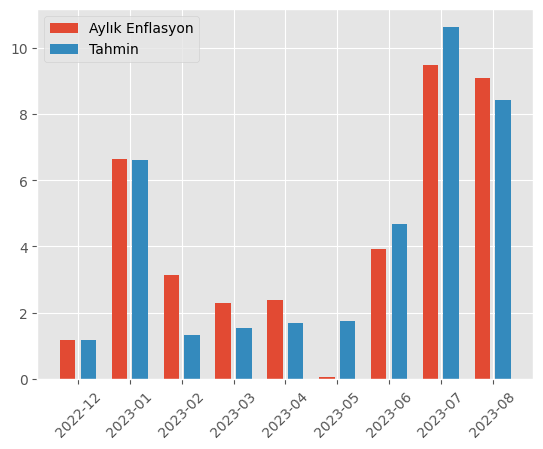

In [486]:
X_axis = np.arange(len(tahminler)) 
plt.bar(X_axis-0.2,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
plt.bar(X_axis+0.2,tahminler["MLP Regression"],width=0.3,label="Tahmin")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.legend()

In [526]:
tahminler

,Aylık Enflasyon,Linear Regression,Bayesian Regression,SGD Regressor,MLP Regression,DNN
2022-12-31,1.182684,1.154488,0.491666,0.755570,1.156638,-0.086713
2023-01-31,6.648943,6.442961,5.536615,5.656903,6.620635,5.553336
2023-02-28,3.145046,2.325847,1.834361,2.096440,1.328223,1.157195
2023-03-31,2.289480,2.556523,2.063013,2.199835,1.530322,0.929415
2023-04-30,2.385509,2.859423,2.260789,2.558161,1.679278,2.002482
2023-05-31,0.043076,1.664966,1.174915,1.357253,1.733118,0.999892
2023-06-30,3.920498,5.838213,5.368442,5.545964,4.676889,4.236957
2023-07-31,9.488824,9.864587,9.509986,9.396762,10.639373,12.164109
2023-08-31,9.086793,7.432736,7.235216,7.264716,8.433949,9.212490


In [488]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sanayi["Sanayi"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(sanayi['Sanayi'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((0, 0, 0), (1, 0, 1, 12))
En iyi RMSE: 6.280256751249998


In [489]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(sanayi["Sanayi"], order=(0, 0, 0), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 13 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Sanayi"]

sanayitahmin=pd.concat([forecast_values],axis=0)
sanayitahmin=sanayitahmin.dropna(axis=0)
sanayitahmin




,Sanayi
2023-09-30,145.946921
2023-10-31,147.303447
2023-11-30,147.965523
2023-12-31,162.075359
2024-01-31,136.439229
2024-02-29,121.134762
2024-03-31,150.344072
2024-04-30,127.461565
2024-05-31,150.240657
2024-06-30,135.097711


In [490]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(perakende1['Mevsimsellikten ve Takvimden Arındırılmış'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((1, 0, 1), (0, 0, 0, 12))
En iyi RMSE: 14.042042793236474


In [491]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 12 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Perakende"]

perakendetahmin=pd.concat([forecast_values],axis=0)
perakendetahmin=perakendetahmin.dropna(axis=0)
perakendetahmin




,Perakende
2023-09-30,175.861239
2023-10-31,175.752870
2023-11-30,175.644568
2023-12-31,175.536333
2024-01-31,175.428164
2024-02-29,175.320062
2024-03-31,175.212026
2024-04-30,175.104057
2024-05-31,174.996155
2024-06-30,174.888319


In [492]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

ar_model = AutoReg(df6['USD/TL'], lags=2)
ar_fit = ar_model.fit()
usdtahmin = ar_fit.predict(start="2023-11-30", end="2024-09-30", dynamic=False)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USD/TL"]
row=pd.DataFrame({"USD/TL":df6["USD/TL"].iloc[-2:]},index=pd.date_range(start="2023-09-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USD/TL
2023-09-30,26.989448
2023-10-31,27.692586
2023-11-30,28.556454
2023-12-31,29.500151
2024-01-31,30.495183
2024-02-29,31.532041
2024-03-31,32.608112
2024-04-30,33.723308
2024-05-31,34.878484
2024-06-30,36.074869


In [493]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d =  range(0, 3)
q=range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(enf_belirsizlik['Enflasyon Belirsizliği'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((1, 0, 0), (0, 0, 0, 12))
En iyi RMSE: 0.7558387398349606


In [494]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"], order=(1, 0, 0), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 12 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Enflasyon Belirsizliği"]

enfbelirsizliktahmin=pd.concat([forecast_values],axis=0)
enfbelirsizliktahmin=enfbelirsizliktahmin.dropna(axis=0)
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-1:,0]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin




,Enflasyon Belirsizliği
2023-09-30,7.300000
2023-10-31,7.210105
2023-11-30,7.121317
2023-12-31,7.033622
2024-01-31,6.947007
2024-02-29,6.861459
2024-03-31,6.776964
2024-04-30,6.693510
2024-05-31,6.611083
2024-06-30,6.529672


In [495]:
from pmdarima.model_selection import train_test_split


model = SARIMAX(df14["Brent"].head(212), order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 12 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
brenttahmin=pd.DataFrame(forecast_values)
brenttahmin.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[211,0]},index=pd.date_range(start="2023-09-30",end="2023-10-30",freq="1M"))
brenttahmin=pd.concat([row,brenttahmin],axis=0)
brenttahmin

,Brent
2023-09-30,93.722381
2023-10-31,103.998520
2023-11-30,103.328042
2023-12-31,95.091426
2024-01-31,101.728188
2024-02-29,106.693041
2024-03-31,113.662796
2024-04-30,111.444192
2024-05-31,110.173843
2024-06-30,114.223845


In [496]:
model = SARIMAX(money["Para Arzi"].head(211), order=(0, 2, 1), seasonal_order=(0, 2, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 13 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
paraarzitahmin=pd.DataFrame(forecast_values)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209,0]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-09-30,113.228626
2023-09-30,122.708118
2023-10-31,127.259994
2023-11-30,131.002207
2023-12-31,134.114630
2024-01-31,138.427688
2024-02-29,142.799972
2024-03-31,147.793937
2024-04-30,153.856342
2024-05-31,156.078953


In [497]:
model = SARIMAX(kfaiz.head(212), order=(0, 1, 2), seasonal_order=(0, 1, 2, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 12 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kfaiztahmin=pd.DataFrame(forecast_values)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[211,0]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-09-30,56.298000
2023-10-31,60.339237
2023-11-30,62.514491
2023-12-31,63.166972
2024-01-31,63.829932
2024-02-29,62.646914
2024-03-31,62.038705
2024-04-30,61.767081
2024-05-31,62.022258
2024-06-30,61.799088


In [498]:
model = SARIMAX(mfaiz.head(212), order=(0, 2, 1), seasonal_order=(2, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 12 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
mfaiztahmin=pd.DataFrame(forecast_values)
mfaiztahmin.columns=["Mevduat Faizi"]
new_row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[211,0]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M"))
mfaiztahmin=pd.concat([new_row,mfaiztahmin],axis=0)
mfaiztahmin

,Mevduat Faizi
2023-09-30,41.656000
2023-10-31,42.532383
2023-11-30,43.879057
2023-12-31,46.731941
2024-01-31,49.622952
2024-02-29,50.509025
2024-03-31,51.586057
2024-04-30,53.267782
2024-05-31,54.862620
2024-06-30,57.836367


In [499]:
usdtahmin["brent"]=brenttahmin
degisim=pd.DataFrame((((usdtahmin["USD/TL"]*usdtahmin["brent"]).pct_change(periods=1)+1).values)[1:],index=pd.date_range(start="2023-10-30",end="2024-10-30",freq="1M"))
degisim.columns=["Değişim"]
degisim

,Değişim
2023-10-31,1.138553
2023-11-30,1.024547
2023-12-31,0.950699
2024-01-31,1.105877
2024-02-29,1.084465
2024-03-31,1.101681
2024-04-30,1.014013
2024-05-31,1.022465
2024-06-30,1.072323
2024-07-31,1.015592


In [500]:
motorintahmin=pd.DataFrame()
motorintahmin["Değişim"]=degisim
motorintahmin["Motorin"]=44.56
for i in range(1,12):
    motorintahmin.iloc[i,1]=motorintahmin.iloc[i,0]*motorintahmin.iloc[i-1,1]

del motorintahmin["Değişim"]
motorintahmin=pd.concat([motorin.tail(1),motorintahmin],axis=0)
motorintahmin

,Motorin
2023-09-30,39.180000
2023-10-31,44.560000
2023-11-30,45.653806
2023-12-31,43.403036
2024-01-31,47.998434
2024-02-29,52.052631
2024-03-31,57.345388
2024-04-30,58.148982
2024-05-31,59.455305
2024-06-30,63.755263


In [501]:
model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1, 2, 0), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 13 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
perakendetahmin=pd.DataFrame(forecast_values)
perakendetahmin.columns=["Perakende Satış"]
perakendetahmin

,Perakende Satış
2023-09-30,172.889609
2023-10-31,167.361304
2023-11-30,162.372977
2023-12-31,157.202266
2024-01-31,152.093158
2024-02-29,146.963242
2024-03-31,141.840355
2024-04-30,136.715094
2024-05-31,131.590634
2024-06-30,126.465904


In [502]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,35,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-09-30",end="2024-10-30",freq="1M"))
zamtahmin

,Zam
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0
2024-06-30,0


In [503]:
model = SARIMAX(data["Kredi"], order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 13 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kreditahmin=pd.DataFrame(forecast_values)
kreditahmin.columns=["Kredi"]
kreditahmin

,Kredi
2023-09-30,0.914480
2023-10-31,1.646478
2023-11-30,2.650646
2023-12-31,2.500304
2024-01-31,1.023724
2024-02-29,0.831675
2024-03-31,2.707252
2024-04-30,3.011096
2024-05-31,2.220475
2024-06-30,3.164212


In [504]:
model = SARIMAX(data["Borç"], order=(1, 2, 1), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 13 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
borctahmin=pd.DataFrame(forecast_values)
borctahmin.columns=["Borç"]
borctahmin

,Borç
2023-09-30,6.239717
2023-10-31,4.390547
2023-11-30,5.572126
2023-12-31,4.968610
2024-01-31,5.311808
2024-02-29,5.264620
2024-03-31,5.254397
2024-04-30,5.884392
2024-05-31,5.349260
2024-06-30,5.348660


In [505]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USD/TL"],paraarzitahmin["Para Arzi"],motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Kredi"]=kreditahmin["Kredi"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["Borç"]=borctahmin["Borç"]
#tahmindf["Mevduat Faizi"]=mfaiztahmin



tahmindf=tahmindf[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi']]


tahmindf.iloc[0,:]=[5.06,4.84,-2.21,56.29,0,-2.22,7.30,5.3,6.239,0.91,41.65]
tahmindf.columns=data.columns[:11]
tahmindf


,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi
2023-09-30,5.060000,4.840000,-2.210000,56.290000,0,-2.220000,7.300000,5.300000,6.239000,0.910000,41.650000
2023-10-31,2.605233,13.731496,-3.197593,60.339237,0,0.929465,7.210105,3.709514,4.390547,1.646478,42.532383
2023-11-30,3.119492,2.454681,-2.980574,62.514491,0,0.449464,7.121317,2.940605,5.572126,2.650646,43.879057
2023-12-31,3.304672,-4.930081,-3.184465,63.166972,0,9.535894,7.033622,2.375855,4.968610,2.500304,46.731941
2024-01-31,3.372973,10.587734,-3.250022,63.829932,35,-15.817414,6.947007,3.215950,5.311808,1.023724,49.622952
2024-02-29,3.400071,8.446519,-3.372877,62.646914,0,-11.217057,6.861459,3.158532,5.264620,0.831675,50.509025
2024-03-31,3.412627,10.168088,-3.485829,62.038705,0,24.113070,6.776964,3.497175,5.254397,2.707252,51.586057
2024-04-30,3.419995,1.401323,-3.613401,61.767081,0,-15.220092,6.693510,4.101931,5.884392,3.011096,53.267782
2024-05-31,3.425453,2.246510,-3.748276,62.022258,0,17.871342,6.611083,1.444601,5.349260,2.220475,54.862620
2024-06-30,3.430151,7.232254,-3.894449,61.799088,0,-10.079126,6.529672,7.082110,5.348660,3.164212,57.836367


In [506]:
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Kredi', 'Mevduat Faizi']
X = data[features]
model = MLPRegressor(random_state=1, max_iter=500000)
model.fit(X, y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin = []
mlptahmin=model.predict(tahmindf[features])
mlptahmin=1+(mlptahmin/100)
for elem in mlptahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin.append(tüfe)
tüfetahmin=pd.DataFrame(tüfetahmin)
tüfetahmin=tüfetahmin.set_index(pd.date_range(start="2023-09-30",end="2024-10-30",freq="1M"))
tüfetahmin.columns=["MLP Regression"]
tüfetahmin

,MLP Regression
2023-09-30,1689.410303
2023-10-31,1780.986076
2023-11-30,1881.384544
2023-12-31,1979.854951
2024-01-31,2071.624418
2024-02-29,2154.018712
2024-03-31,2242.226486
2024-04-30,2345.268362
2024-05-31,2440.136099
2024-06-30,2520.399308


In [507]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği']


X = data[features]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X, y)

tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin1 = []
sgdtahmin=reg.predict(tahmindf[features])
sgdtahmin=1+(sgdtahmin/100)
for elem in sgdtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin1.append(tüfe)
tüfetahmin1=pd.DataFrame(tüfetahmin1)
tüfetahmin1=tüfetahmin1.set_index(pd.date_range(start="2023-09-30",end="2024-10-30",freq="1M"))
tüfetahmin1.columns=["SGD Regressor"]

tüfetahmin1

,SGD Regressor
2023-09-30,1674.649008
2023-10-31,1762.707083
2023-11-30,1822.287150
2023-12-31,1861.831583
2024-01-31,1979.453580
2024-02-29,2064.715607
2024-03-31,2159.089615
2024-04-30,2226.692333
2024-05-31,2299.161248
2024-06-30,2392.329641


In [508]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği']


X = data[features]
reg = linear_model.BayesianRidge()
reg.fit(X, y)

tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin2 = []
bayesiantahmin=reg.predict(tahmindf[features])
bayesiantahmin=1+(bayesiantahmin/100)
for elem in bayesiantahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin2.append(tüfe)
tüfetahmin2=pd.DataFrame(tüfetahmin2)
tüfetahmin2=tüfetahmin2.set_index(pd.date_range(start="2023-09-30",end="2024-10-30",freq="1M"))
tüfetahmin2.columns=["Bayesian Regression"]

tüfetahmin2




,Bayesian Regression
2023-09-30,1672.786828
2023-10-31,1759.273806
2023-11-30,1817.156572
2023-12-31,1856.073629
2024-01-31,1972.446198
2024-02-29,2054.318935
2024-03-31,2149.692820
2024-04-30,2213.203300
2024-05-31,2286.062070
2024-06-30,2375.528686


In [532]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği']

X = data[features]
model=sm.OLS(y,X).fit()


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin3 = []
lineartahmin=model.predict(tahmindf[features])
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin3.append(tüfe)
tüfetahmin3=pd.DataFrame(tüfetahmin3)
tüfetahmin3=tüfetahmin3.set_index(pd.date_range(start="2023-09-30",end="2024-10-30",freq="1M"))
tüfetahmin3.columns=["Linear Regression"]

tüfetahmin3

,Linear Regression
2023-09-30,1677.302972
2023-10-31,1767.981060
2023-11-30,1830.250577
2023-12-31,1872.403270
2024-01-31,1992.690920
2024-02-29,2080.768033
2024-03-31,2178.023736
2024-04-30,2248.296485
2024-05-31,2323.405243
2024-06-30,2419.329509


In [599]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import  KerasRegressor
from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense

features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'ParaArzi', 'Borç', 'Mevduat Faizi']

X = data[features]
model = tf.keras.models.Sequential()
model.add(Dense(units=32,input_dim=X.shape[1],activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.01),loss="mae",metrics=["mae"])
cıktı=model.fit(X,y,epochs=100,verbose=0)


 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin4 =[]
dnntahmin=model.predict(tahmindf[features])
dnntahmin=1+(dnntahmin/100)
tüfe = [1614]

tufe_degerleri = tüfe
for oran in dnntahmin:
    tufe_degerleri.append(tufe_degerleri[-1] * oran)

# DataFrame oluştur
tüfetahmin4 = pd.DataFrame({'DNN': tufe_degerleri},index=pd.date_range(start="2023-08-30",end="2024-10-30",freq="1M"))

tüfetahmin4["DNN"]=tüfetahmin4["DNN"].astype(float)
tüfetahmin4=tüfetahmin4.tail(13)
tüfetahmin4

1/1 [==============================] - 0s 60ms/step


,DNN
2023-09-30,1692.186157
2023-10-31,1784.721313
2023-11-30,1863.633545
2023-12-31,1930.658569
2024-01-31,2058.117188
2024-02-29,2167.071777
2024-03-31,2277.814209
2024-04-30,2390.246582
2024-05-31,2487.341797
2024-06-30,2640.954346


In [600]:
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Bayesian Regression"]=tüfetahmin2["Bayesian Regression"]
tüfetahmin["Linear Regression"]=tüfetahmin3["Linear Regression"]
tüfetahmin["DNN"]=tüfetahmin4["DNN"]
tüfetahmin

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,DNN
2023-09-30,1689.410303,1674.649008,1672.786828,1677.302972,1692.186157
2023-10-31,1780.986076,1762.707083,1759.273806,1767.981060,1784.721313
2023-11-30,1881.384544,1822.287150,1817.156572,1830.250577,1863.633545
2023-12-31,1979.854951,1861.831583,1856.073629,1872.403270,1930.658569
2024-01-31,2071.624418,1979.453580,1972.446198,1992.690920,2058.117188
2024-02-29,2154.018712,2064.715607,2054.318935,2080.768033,2167.071777
2024-03-31,2242.226486,2159.089615,2149.692820,2178.023736,2277.814209
2024-04-30,2345.268362,2226.692333,2213.203300,2248.296485,2390.246582
2024-05-31,2440.136099,2299.161248,2286.062070,2323.405243,2487.341797
2024-06-30,2520.399308,2392.329641,2375.528686,2419.329509,2640.954346


In [601]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[1:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[1:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]

dfas3=pd.DataFrame()
dfas3=pd.concat([df["CPI"],tüfetahmin.iloc[1:,2]],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=[tüfetahmin.columns[2]]

dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[1:,3]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[3]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[4]]



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas3,dfas4,dfas5],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








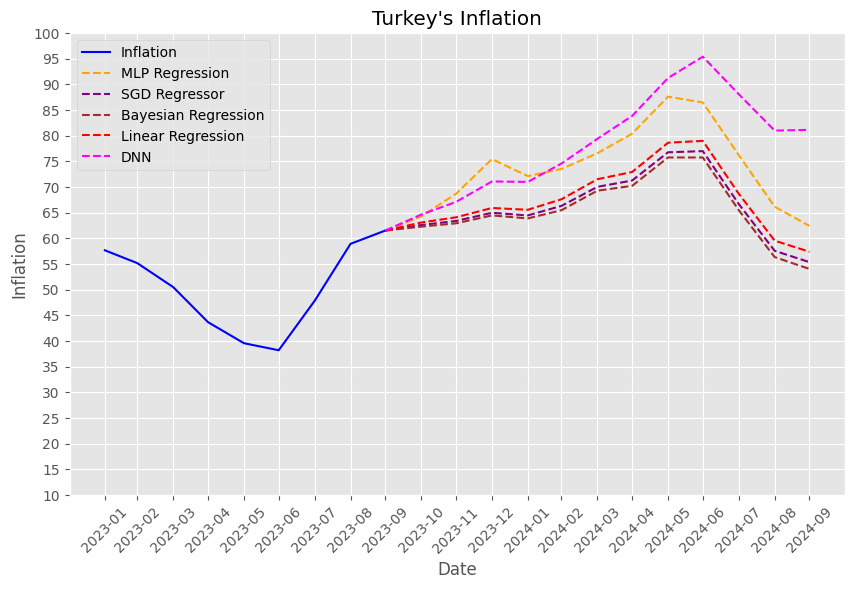

In [603]:








# Grafik çizdirelim
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[191:200,1], label='Inflation', color='blue')
plt.plot(dfas.iloc[199:,0],'--',label=dfas.columns[0], color='orange')
plt.plot(dfas.iloc[199:,1],'--',label=dfas.columns[1], color='purple')
plt.plot(dfas.iloc[199:,2],'--',label=dfas.columns[2], color='brown')
plt.plot(dfas.iloc[199:,3],'--',label=dfas.columns[3], color='red')
plt.plot(dfas.iloc[199:,4],'--',label=dfas.columns[4], color='magenta')


plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dfas.iloc[191:].index, dfas.iloc[191:].index.strftime('%Y-%m'), rotation=45)
y_max = 100
y_min = 10
y_interval = 0.5
y_ticks = [y_min]
while y_ticks[-1] < y_max:
    y_ticks.append(y_ticks[-1] + 5)









# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation")
plt.legend()
plt.grid(True)
plt.show()


#VAR ve VECM modelleri neredeyse aynı tahmini yaptığından üst üste gelmiş olarak gözüküyor.

In [604]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,DNN,Ortalama
2023-10-31,5.420576,5.258300,5.170233,5.406184,5.468379,5.344735
2023-11-30,5.637240,3.380032,3.290151,3.522069,4.421544,4.050207
2023-12-31,5.233933,2.170044,2.141646,2.303111,3.596470,3.089041
2024-01-31,4.635161,6.317542,6.269825,6.424238,6.601821,6.049718
2024-02-29,3.977280,4.307352,4.150822,4.420009,5.293896,4.429872
2024-03-31,4.095033,4.570799,4.642604,4.674029,5.110234,4.618540
2024-04-30,4.595516,3.131075,2.954398,3.226446,4.935976,3.768682
2024-05-31,4.045070,3.254554,3.292005,3.340696,4.062142,3.598894
2024-06-30,3.289292,4.052277,3.913569,4.128607,6.175772,4.311903
2024-07-31,3.478125,3.118860,3.105312,3.186985,5.396664,3.657189


In [605]:
yıllıktahmin=pd.DataFrame(dfas)
yıllıktahmin["Ortalama"]=dfas.mean(axis=1)
yıllıktahmin.tail(12)

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,DNN,Ortalama
2023-10-31,64.297609,62.611354,62.294632,63.097884,64.642188,63.388733
2023-11-30,68.694703,63.395724,62.935690,64.109766,67.103056,65.247788
2023-12-31,75.449063,64.990171,64.479918,65.927003,71.089421,68.387115
2024-01-31,72.136173,64.477480,63.895220,65.577402,71.013826,67.420020
2024-02-29,73.525067,66.330920,65.493377,67.624083,74.576606,69.510010
2024-03-31,76.588028,70.040529,69.300478,71.531698,79.390763,73.370299
2024-04-30,80.399708,71.278756,70.241169,72.940562,83.859464,75.743932
2024-05-31,87.616185,76.776968,75.769804,78.641030,91.245717,82.009941
2024-06-30,86.476617,77.001135,75.758084,78.998773,95.396115,82.726145
2024-07-31,76.239454,66.703363,65.510885,68.696155,88.093158,73.048603
